In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from numba import jit, float64, int64

In [2]:
# @jit(nopython=True)
def simulate_HSDM_2D(threshold, mu, ndt, sigma=1, dt=0.001):
    x = np.zeros(mu.shape)
    
    rt = 0
    
    while np.linalg.norm(x, 2) < threshold(rt):
        x += mu*dt + sigma*np.sqrt(dt)*np.random.normal(0, 1, mu.shape)
        rt += dt
    
    theta = np.arctan2(x[1], x[0])   
    
    return ndt+rt, theta

In [3]:
data = pd.read_csv('_data/Kvam_2019_orientation_judgments_data.csv')
data = data[data['isCued'] == 0].reset_index(drop=True)
data['absoluteDeviation'] = data['absoluteDeviation']/np.pi * 180

# best_fitting = pd.read_csv('Kvam_2019_best_estimation.csv', index_col=0)
best_fitting = pd.read_csv('Kvam_2019_collapsing_best_estimation.csv', index_col=0)
best_fitting['drift magnitude'] = np.sqrt(best_fitting['mux']**2 + best_fitting['muy']**2)
best_fitting['drift direction'] = np.arctan2(best_fitting['muy'], best_fitting['mux'])
best_fitting['drift direction'] = np.abs(best_fitting['drift direction']/np.pi * 180)

In [4]:
best_fitting.describe()

,sbj,isSpeed,jitter,b0,lambda,mux,muy,ndt,G2,drift magnitude,drift direction
count,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000
mean,150.083333,0.500000,30.000000,2.595990,1.091731,4.424855,-0.034271,0.225356,-327.447546,4.431035,2.631197
std,37.792148,0.503509,12.333397,1.649115,1.885667,2.005744,0.221674,0.101075,152.047742,2.004455,2.150792
min,100.000000,0.000000,15.000000,0.892257,0.000000,1.603044,-0.604510,0.100000,-690.332754,1.605901,0.003486
25%,117.500000,0.000000,15.000000,1.281973,0.000000,2.830384,-0.169480,0.131398,-401.193957,2.835691,0.943464
50%,145.000000,0.500000,30.000000,1.899471,0.010000,3.828945,-0.007373,0.224960,-308.580607,3.829257,2.152956
75%,182.500000,1.000000,45.000000,3.471194,0.951461,5.717557,0.103013,0.304085,-226.376960,5.720612,3.921274
max,210.000000,1.000000,45.000000,6.000000,5.000000,8.000000,0.494843,0.439740,-51.612712,8.011992,10.701759


In [5]:
prediction = {'sbj': [],
              'isSpeed': [],
              'jitter':[],
              'Theta':[],
              'RT':[]}

for sbj in data['Participant'].unique():
    prms_sbj = best_fitting[best_fitting['sbj']==sbj]
    for sp in range(2):
        for jit in [15, 30, 45]:
            prms_cond = prms_sbj[(prms_sbj['isSpeed']==sp) & (prms_sbj['jitter']==jit)]
#             threshold = lambda t: prms_cond['threshold'].values[0]
            threshold = lambda t: prms_cond['b0'].values[0] - prms_cond['lambda'].values[0]*t
            ndt = prms_cond['ndt'].values[0]
            mu = np.array([prms_cond['mux'].values[0], 
                           prms_cond['muy'].values[0]])
            

            for n in range(300):
                rt, theta = simulate_HSDM_2D(threshold, mu, ndt)
                prediction['sbj'].append(sbj)
                prediction['isSpeed'].append(sp)
                prediction['jitter'].append(jit)
                prediction['Theta'].append(np.abs(theta)/np.pi * 180)
                prediction['RT'].append(rt)
            

In [6]:
prediction_df = pd.DataFrame(prediction)
prediction_df

,sbj,isSpeed,jitter,Theta,RT
0,100,0,15,28.288488,0.664000
1,100,0,15,31.605498,0.867000
2,100,0,15,20.738437,0.660000
3,100,0,15,10.040314,1.216000
4,100,0,15,23.001324,1.056000
...,...,...,...,...,...
21595,210,1,45,31.687467,0.793461
21596,210,1,45,18.977087,0.663461
21597,210,1,45,3.101554,0.671461
21598,210,1,45,45.179820,0.653461


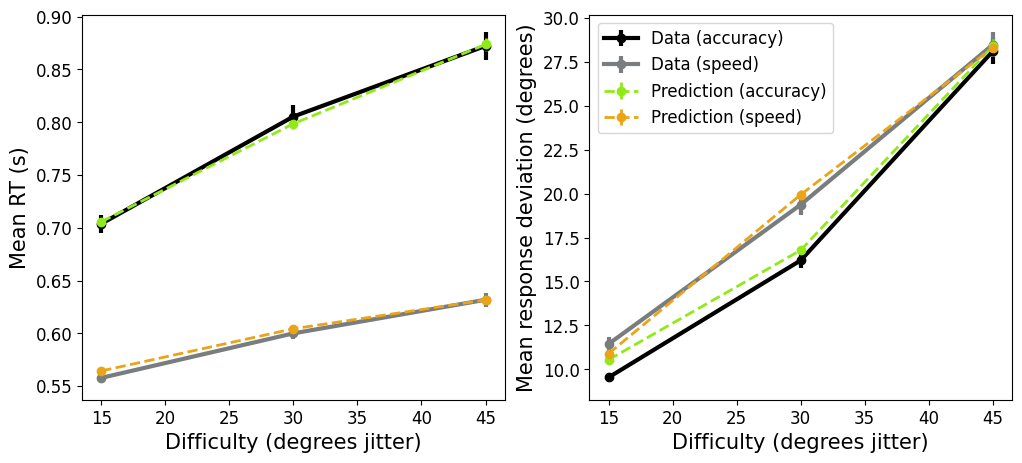

In [7]:
plt.figure(figsize=(12, 5))

plt.rc('axes', titlesize=15)     # fontsize of the axes title
plt.rc('axes', labelsize=15)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('legend', fontsize=12)    # legend fontsize

plt.subplot(121)
GRT = data.groupby(by=['jitter', 'isSpeed'])['RT'].mean()
GRT_err = data.groupby(by=['jitter', 'isSpeed'])['RT'].sem()
plt.errorbar(x=[15, 30, 45],
             y=GRT.iloc[0::2],
             yerr=GRT_err.iloc[0::2], fmt='-o', linewidth=3, c='black', label='Data (accuracy)')
plt.errorbar(x=[15, 30, 45],
             y=GRT.iloc[1::2],
             yerr=GRT_err.iloc[1::2], fmt='-o', linewidth=3, c='#797d7f', label='Data (speed)')

GRT = prediction_df.groupby(by=['jitter', 'isSpeed'])['RT'].mean()
GRT_err = prediction_df.groupby(by=['jitter', 'isSpeed'])['RT'].sem()
plt.errorbar(x=[15, 30, 45],
             y=GRT.iloc[0::2],
             yerr=GRT_err.iloc[0::2], linewidth=2, fmt='--o', c='#91ea18')
plt.errorbar(x=[15, 30, 45],
             y=GRT.iloc[1::2],
             yerr=GRT_err.iloc[1::2], linewidth=2, fmt='--o', c='#eaa418')
plt.xlabel('Difficulty (degrees jitter)')
plt.ylabel('Mean RT (s)')


plt.subplot(122)
GERR = data.groupby(by=['jitter', 'isSpeed'])['absoluteDeviation'].mean()
GERR_err = data.groupby(by=['jitter', 'isSpeed'])['absoluteDeviation'].sem()
plt.errorbar(x=[15, 30, 45],
             y=GERR.iloc[0::2],
             yerr=GERR_err.iloc[0::2], fmt='-o', linewidth=3, c='black', label='Data (accuracy)')
plt.errorbar(x=[15, 30, 45],
             y=GERR.iloc[1::2],
             yerr=GERR_err.iloc[1::2], fmt='-o', linewidth=3, c='#797d7f', label='Data (speed)')

GERR = prediction_df.groupby(by=['jitter', 'isSpeed'])['Theta'].mean()
GERR_err = prediction_df.groupby(by=['jitter', 'isSpeed'])['Theta'].sem()
plt.errorbar(x=[15, 30, 45],
             y=GERR.iloc[0::2],
             yerr=GERR_err.iloc[0::2], linewidth=2, fmt='--o', c='#91ea18', label='Prediction (accuracy)')
plt.errorbar(x=[15, 30, 45],
             y=GERR.iloc[1::2],
             yerr=GERR_err.iloc[1::2], linewidth=2, fmt='--o', c='#eaa418', label='Prediction (speed)')
plt.xlabel('Difficulty (degrees jitter)')
plt.ylabel('Mean response deviation (degrees)');
plt.legend();

# plt.savefig('../_01_Figures/CDM_prediction_Kvam2019.pdf', 
#             transparent=True, 
#             dpi=600, 
#             bbox_inches='tight');